# Unsteady diffusion + reaction 1/2/3D

Reaction: $A \rightarrow B\rightarrow C$

$\frac{\partial c_A}{\partial t} + \mathrm{div}(-D \, \mathrm{grad}(c_A)) = -k_1 \, c_A$

$\frac{\partial c_B}{\partial t} + \mathrm{div}(-D \, \mathrm{grad}(c_B)) = k_1 \, c_A - k_2 \, c_B$

$\frac{\partial c_C}{\partial t} + \mathrm{div}(-D \, \mathrm{grad}(c_C)) = k_2 \, c_B$

with boundary conditions: $c_A= c_w , c_B=0, c_C(0)=0$

The setup of this problem is more complex than is stricktly necesarry. The puprose is to demonstrate that models can be build in such a way that they can be used in 1, 2 or 3 dimensions.
For 1D and 2D it was found that the direct sparse LU solver works well. For 3D it seems very slow and BiCGStab with an ILU preconditioner is used. Note that the ILU preconditioner takes some time in this case. 

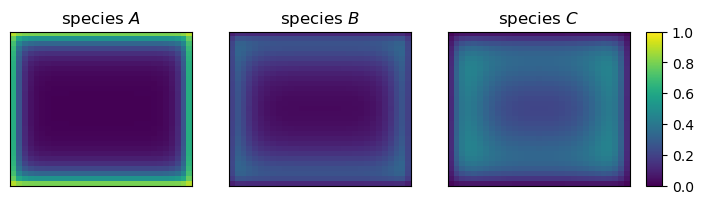

In [1]:
import math
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from pymrm import construct_grad, construct_div, NumJac

def reaction(c, k_1, k_2, axis = -1):
    shape_c = c.shape
    shape_t = [math.prod(shape_c[:axis]),shape_c[axis], -1]
    c = c.reshape(shape_t)
    r = np.zeros_like(c)
    r[:,0,:] = -k_1*c[:,0,:]
    r[:,1,:] =  k_1*c[:,0,:] - k_2*c[:,1,:]
    r[:,2,:] =  k_2*c[:,1,:]
    return r.reshape(shape_c)

dim = 2
L = [0.2] * dim
L[0] = 0.1
D = 1e-4
k_1 = 2.0
k_2 = 1.0
t_end = 5
num_c = 3
c_b = np.array([1.0] + [0.0]*(num_c-1)).reshape((1,)*(dim-1)+(-1,)).reshape((1,)*dim + (-1,))

shape_c = [31] * dim + [num_c]
num_time_steps = 1000
num_inner_iter = 1
output_interval = 100 #num_time_steps
dt = t_end / num_time_steps
c = np.zeros(shape_c)
numjac = NumJac(shape_c)

# All boundaries Dirichlet bc, with c=0. By making sizes=1 broadcasting will be used.
bc = {'a': 0, 'b': 1, 'd': c_b}
x_f = [None]*dim
x_c = [None]*dim
Flux = [None]*dim
flux_bc = [None]*dim
Jac = sp.sparse.eye(math.prod(shape_c), format='csc')/dt
g_const = np.zeros((math.prod(shape_c),1))
for i in range(dim):
    x_f[i] = np.linspace(0,L[i],shape_c[i]+1)
    x_c[i] = 0.5*(x_f[i][:-1]+x_f[i][1:])
    Grad, grad_bc = construct_grad(shape_c, x_f[i], x_c[i], bc=(bc,bc), axis=i)
    Flux[i] = -D*Grad
    flux_bc[i] = - D*grad_bc
    Div = construct_div(shape_c, x_f[i], nu=0, axis=i)
    Jac += Div @ (Flux[i])
    g_const += Div @ (flux_bc[i])
f_react, Jac_react = numjac(lambda c: reaction(c, k_1, k_2, axis=-1), c)
Jac_react.eliminate_zeros()
Jac -= Jac_react
if (dim==3):
    Jac_ilu = sla.spilu(Jac)
    Jac_pc = sla.LinearOperator(Jac_ilu.shape, lambda x: Jac_ilu.solve(x))
else:
    Jac_lu = sla.splu(Jac)
 
labels = [r'$A$',r'$B$',r'$C$']
if (dim ==1):
    fig, ax = plt.subplots()
    lines = [ax.plot(x_c[0], c[:, j], label=labels[j])[0] for j in range(num_c)]
    plt.ylim(0,1.1)
    ax.set_xlabel('position')
    ax.set_ylabel('concentration')
    plt.legend()
elif ((dim ==2) | (dim==3)):
    fig, ax = plt.subplots(1,num_c, figsize=(8, 2))
    for i in range(num_c):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_title(f'species {labels[i]}')
    contour = [None] * num_c  
    if (dim==2):
        for i in range(num_c):    
            contour[i] = ax[i].pcolormesh(x_f[0], x_f[1], c[:,:, i], shading='flat', cmap='viridis', vmin=0, vmax=1)
    else:
        indx_z = math.floor(shape_c[dim-1]/2)
        for i in range(num_c):
            contour[i] = ax[i].pcolormesh(x_f[0], x_f[1], c[:,:,indx_z, i], shading='flat', cmap='viridis', vmin=0, vmax=1)    
    cbar_ax = fig.add_axes([0.92, ax[0].get_position().y0, 0.02, ax[0].get_position().y1-ax[0].get_position().y0])  # Adjust the parameters as needed [left, bottom, width, height]
    plt.colorbar(contour[0], cax=cbar_ax)
plt.show()

for i in range(num_time_steps):
    c_old = c.copy().reshape((-1,1))
    for j in range(num_inner_iter):
        g = g_const + Jac @ c.reshape((-1,1)) - c_old/dt
        if (dim==3):
            dc, exit_code = sla.bicgstab(Jac, g, M=Jac_pc)
            c -= dc.reshape(c.shape)
        else:
            c -= Jac_lu.solve(g).reshape(c.shape)
#        clear_output(wait=True)
#        display(f'solving: progress {100*i/num_time_steps}%')
    if ((i+1) % output_interval == 0):
        clear_output(wait=True)
        if (dim==1):
            for j in range(num_c):
                lines[j].set_ydata(c[:, j])  
        elif (dim==2):
            for i in range(num_c):
                contour[i].set_array(c[:,:,i].ravel())
        elif (dim==3):
            for i in range(num_c):
                contour[i].set_array(c[:,:,indx_z,i].ravel())
        display(fig)